In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

#### With the latest US GDP Q2 results, the US is now officially in a recession after the US economy has contracted for two quarters in a row. While there is also a sharp downturn in the stock market as well, we will forecast prices for several stocks in this notebook to see which stocks can do better during a recession. 

<div>
<img src="https://media.istockphoto.com/photos/economy-crash-picture-id1214458453?k=20&m=1214458453&s=612x612&w=0&h=Uw1BH96w1hZXoe4JzGpcv7PpTeHCatP2su7W9se7Pvw=" width="800" height="300"/>
</div>

### Import Dataset

Import TSLA financial market data with `pandas_datareader`

In [3]:
import pandas as pd
import pandas_datareader as pdr

api = 'MO9PZF0QEFE491CN'
ts = pdr.av.time_series.AVTimeSeriesReader('TSLA', api_key=api)
TSLA = ts.read()
TSLA.index = pd.to_datetime(TSLA.index, format='%Y-%m-%d')
TSLA

,open,high,low,close,volume
2010-06-29,19.00,25.0000,17.54,23.89,18766300
2010-06-30,25.79,30.4192,23.30,23.83,17187100
2010-07-01,25.00,25.9200,20.27,21.96,8218800
2010-07-02,23.00,23.1000,18.71,19.20,5139800
2010-07-06,20.00,20.0000,15.83,16.11,6866900
...,...,...,...,...,...
2022-08-17,910.19,928.9700,900.10,911.99,22921990
2022-08-18,918.00,919.5000,905.56,908.61,15833512
2022-08-19,897.00,901.0800,877.50,890.00,20465129
2022-08-22,875.74,877.2000,858.89,869.74,18614449


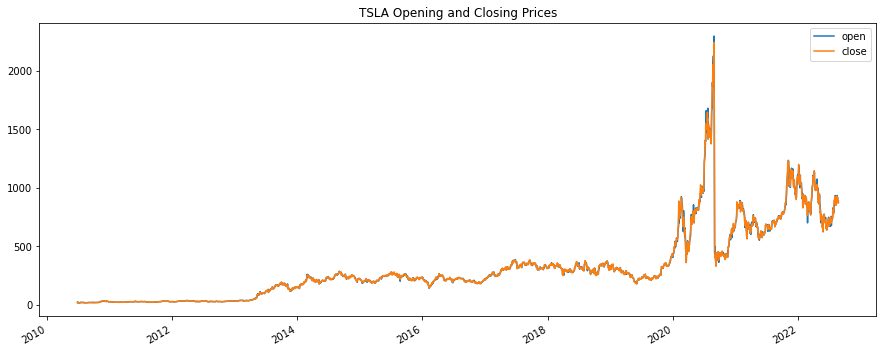

In [4]:
TSLA[['open','close']].plot(figsize=(15, 6), title='TSLA Opening and Closing Prices');

We will run forecasting based on open prices for the next year. Reframe the data by renaming columns as *prophet* requires the dataframe to have only two columns named *ds* and *y* for datetime and values, respectively.

In [5]:
TSLA = TSLA.reset_index().rename(columns={'index': 'ds', 'open': 'y'})[['ds', 'y']]
TSLA

,ds,y
0,2010-06-29,19.00
1,2010-06-30,25.79
2,2010-07-01,25.00
3,2010-07-02,23.00
4,2010-07-06,20.00
...,...,...
3055,2022-08-17,910.19
3056,2022-08-18,918.00
3057,2022-08-19,897.00
3058,2022-08-22,875.74


Split the dataset, and build model:

In [6]:
X = TSLA.iloc[:-5*40]
y = TSLA.iloc[-5*40:]

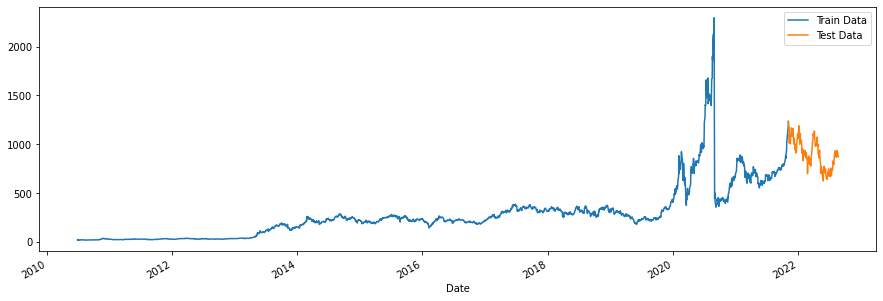

In [7]:
ax = X.set_index('ds').y.plot(figsize=(15, 5), label='Train Data')
y.set_index('ds').y.plot(figsize=(15, 5), label='Test Data')


ax.set_xlabel('Date')
ax.legend()

### Build forecasting model

In [8]:
from prophet import Prophet

m = Prophet()
m.fit(X)

14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing


Since the stock price dataset has only business days, calculate the exact difference between X and y to make future dataframe:

In [9]:
exact_days =  (y.iloc[-1].ds - X.iloc[-1].ds).days
exact_days

292

In [10]:
future = m.make_future_dataframe(exact_days)
future

,ds
0,2010-06-29
1,2010-06-30
2,2010-07-01
3,2010-07-02
4,2010-07-06
...,...
3147,2022-08-19
3148,2022-08-20
3149,2022-08-21
3150,2022-08-22


Now, drop weekends from future:

In [11]:
future2 = future.copy()
future2[future.ds.dt.dayofweek < 5]

,ds
0,2010-06-29
1,2010-06-30
2,2010-07-01
3,2010-07-02
4,2010-07-06
...,...
3145,2022-08-17
3146,2022-08-18
3147,2022-08-19
3150,2022-08-22


In [12]:
forecast = m.predict(future2)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-06-29,9.131135,-171.656554,215.839822,9.131135,9.131135,22.928100,22.928100,22.928100,-1.811270,-1.811270,-1.811270,24.739369,24.739369,24.739369,0.0,0.0,0.0,32.059235
1,2010-06-30,9.175449,-150.493309,224.232405,9.175449,9.175449,26.323297,26.323297,26.323297,-1.173717,-1.173717,-1.173717,27.497014,27.497014,27.497014,0.0,0.0,0.0,35.498746
2,2010-07-01,9.219762,-144.184994,244.792647,9.219762,9.219762,29.297350,29.297350,29.297350,-1.103528,-1.103528,-1.103528,30.400878,30.400878,30.400878,0.0,0.0,0.0,38.517113
3,2010-07-02,9.264076,-145.226788,229.985993,9.264076,9.264076,30.788473,30.788473,30.788473,-2.616633,-2.616633,-2.616633,33.405106,33.405106,33.405106,0.0,0.0,0.0,40.052549
4,2010-07-06,9.441331,-154.947540,228.493250,9.441331,9.441331,43.577898,43.577898,43.577898,-1.811270,-1.811270,-1.811270,45.389168,45.389168,45.389168,0.0,0.0,0.0,53.019230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,2022-08-19,1063.645371,956.736113,1336.756285,1048.579105,1077.895298,83.437862,83.437862,83.437862,-2.616633,-2.616633,-2.616633,86.054495,86.054495,86.054495,0.0,0.0,0.0,1147.083233
3148,2022-08-20,1064.231825,958.362692,1339.096881,1049.057543,1078.548728,89.689403,89.689403,89.689403,4.933858,4.933858,4.933858,84.755545,84.755545,84.755545,0.0,0.0,0.0,1153.921228
3149,2022-08-21,1064.818278,968.983844,1342.110800,1049.551605,1079.202806,87.659692,87.659692,87.659692,4.933857,4.933857,4.933857,82.725835,82.725835,82.725835,0.0,0.0,0.0,1152.477970
3150,2022-08-22,1065.404731,954.240541,1335.628706,1049.974177,1079.916833,76.799334,76.799334,76.799334,-3.162567,-3.162567,-3.162567,79.961901,79.961901,79.961901,0.0,0.0,0.0,1142.204065


### Comparing and Evaluation

Compare predicted prices with actual test prices on a plot:

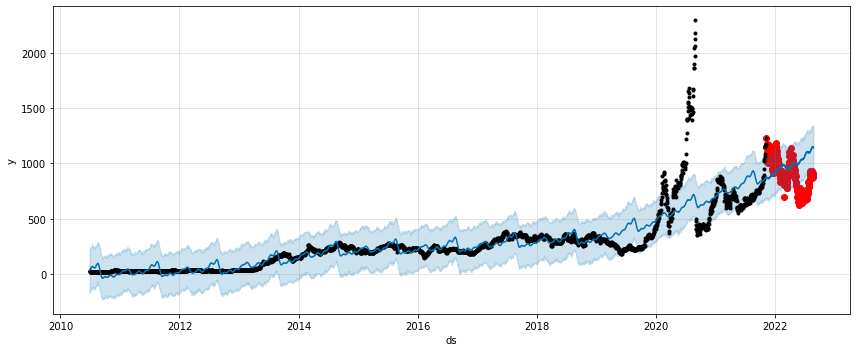

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(y.ds, y.y, color='r')
m.plot(forecast, ax=ax);

Get component plots:

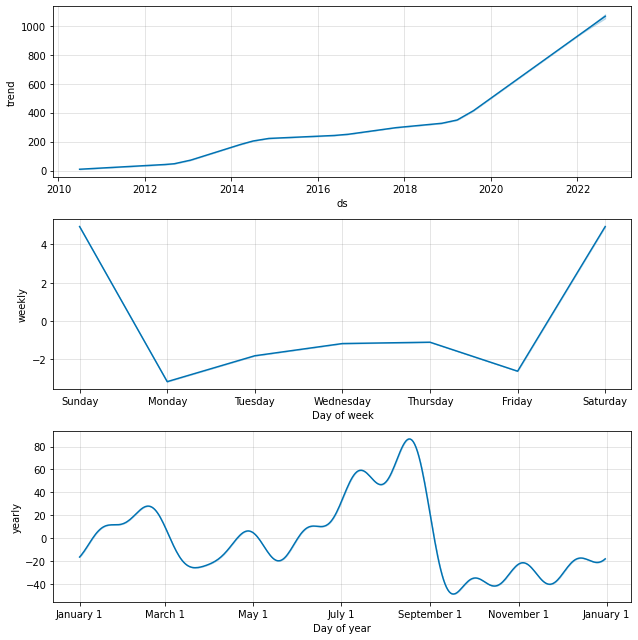

In [14]:
m.plot_components(forecast);

We see that TSLA has been on a remarkable increase trend for the last two years, and generally have a peak around Augusts and show a sharp decline afterwards.

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 

def evaluate(test, forecast):
    metrics = [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error]
    results = []
    for metric in metrics:
         results.append(metric(test.y, forecast['yhat'].iloc[-(len(test)):]))
    return results  

In [16]:
results = evaluate(y, forecast)
'MAE:{}, RMSE:{}, MAPE:{}'.format(results[0], np.sqrt(results[1]), results[2]*100) 

'MAE:182.37068235059112, RMSE:222.92622358631982, MAPE:22.706649856787166'

In [17]:
TSLA.describe().T

,count,mean,std,min,25%,50%,75%,max
y,3060.0,317.914773,305.206788,16.14,120.2725,238.145,351.91,2295.12


Now, forecast the prices for the coming 48 weeks:

In [18]:
def forecast_stock(df, week_len):
    m = Prophet()
    m.fit(df)
    
    future = m.make_future_dataframe(7*week_len)
    future = future[future.ds.dt.dayofweek < 5]
    
    forecast = m.predict(future)
    
    return m, forecast

In [19]:
week_len = 48
m, future_forecast = forecast_stock(TSLA, week_len)

14:32:33 - cmdstanpy - INFO - Chain [1] start processing
14:32:34 - cmdstanpy - INFO - Chain [1] done processing


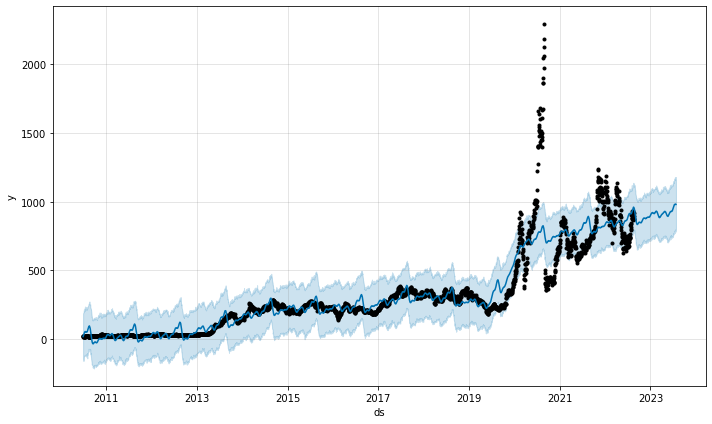

In [20]:
m.plot(future_forecast,);

Note that the forecasting result turned out to be downward when we include the last 40 weeks' prices.

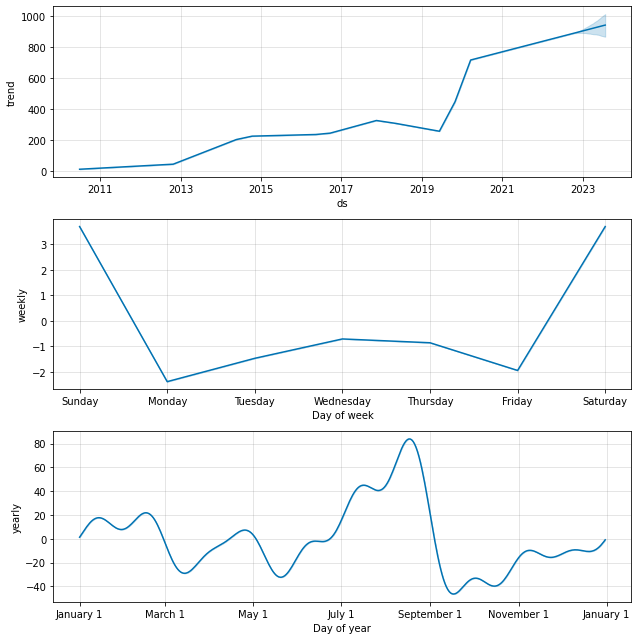

In [21]:
m.plot_components(future_forecast);

### Forecasting for Multiple Stocks at Once

Get forecasting results for multiple stocks at once:

In [22]:
def forecast_all(stock_list, week_len):    
    for idx, stock in enumerate(stock_list):
        ts = pdr.av.time_series.AVTimeSeriesReader(stock, api_key=api)
        df = ts.read()
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
        df = df.reset_index().rename(columns={'index': 'ds', 'open': 'y'})[['ds', 'y']]
        
        m, f = forecast_stock(df, week_len)
        fig = m.plot(f, ylabel=f'{stock} price')
        ax = fig.gca()
        ax.set_title(f'{stock} price', size=34)
        m.plot_components(f)
        

14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing
14:32:57 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:09 - cmdstanpy - INFO - Chain [1] done processing
14:33:18 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing


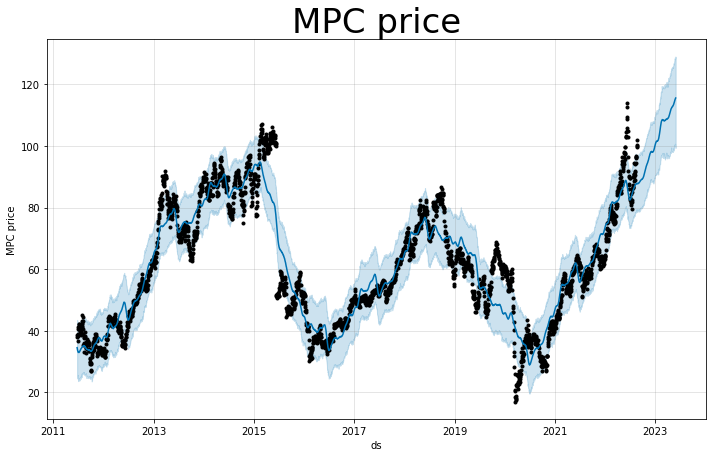

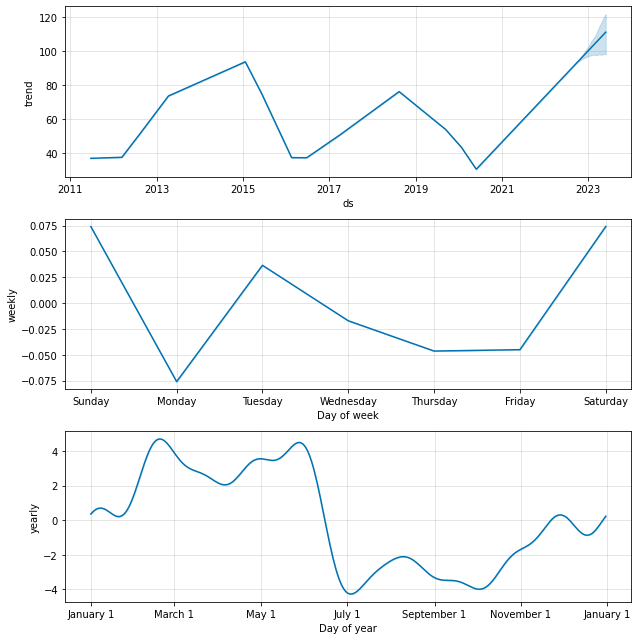

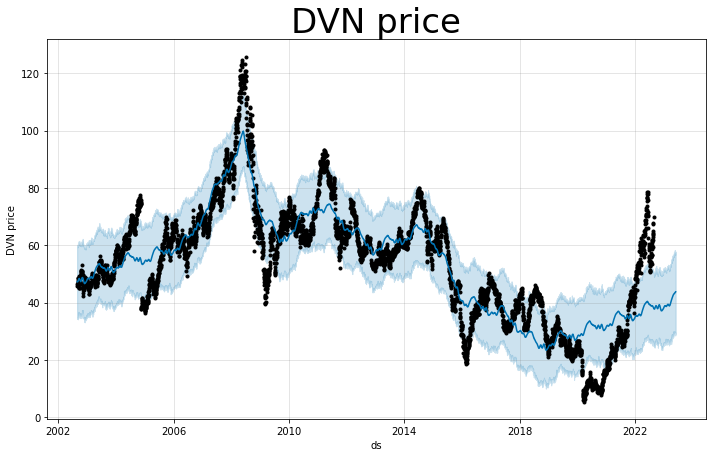

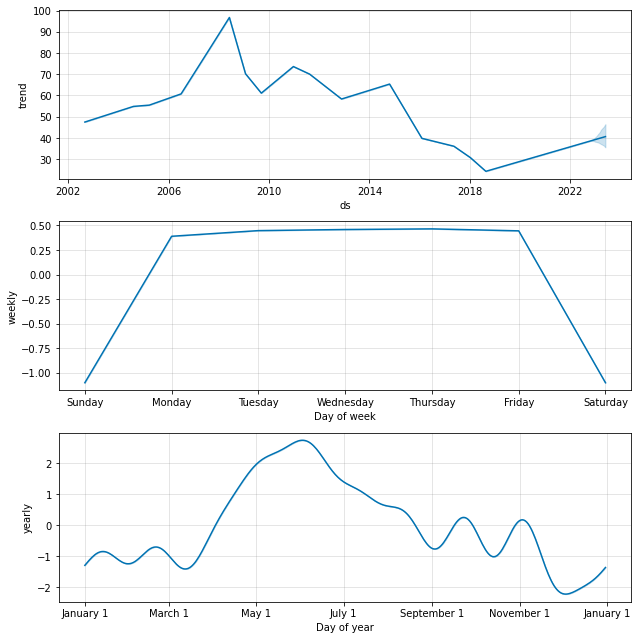

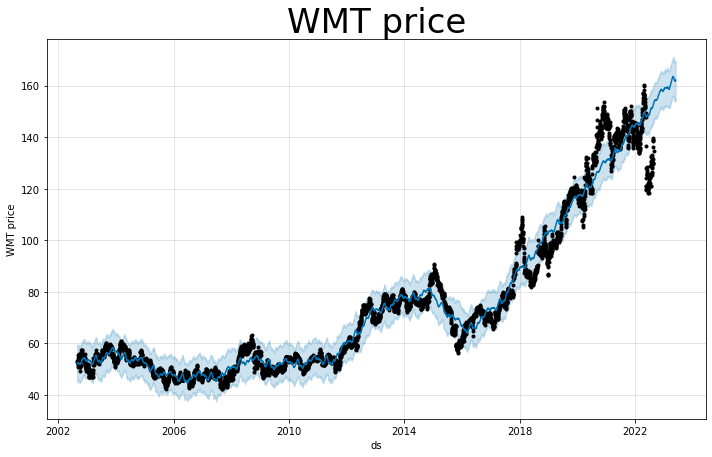

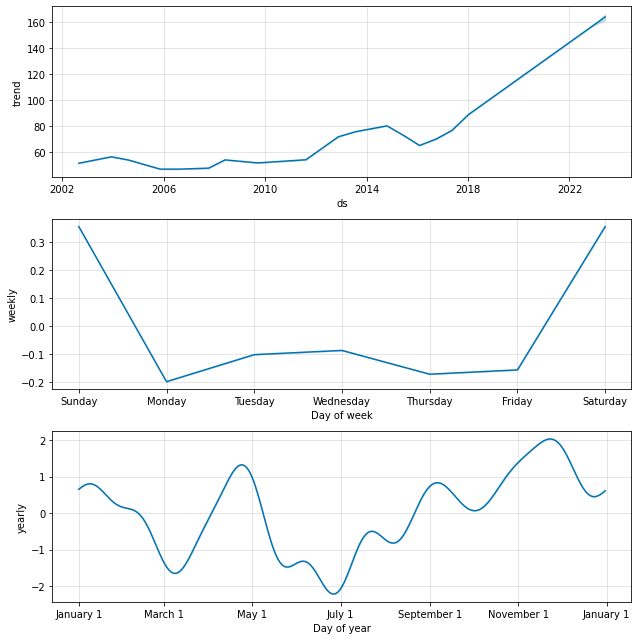

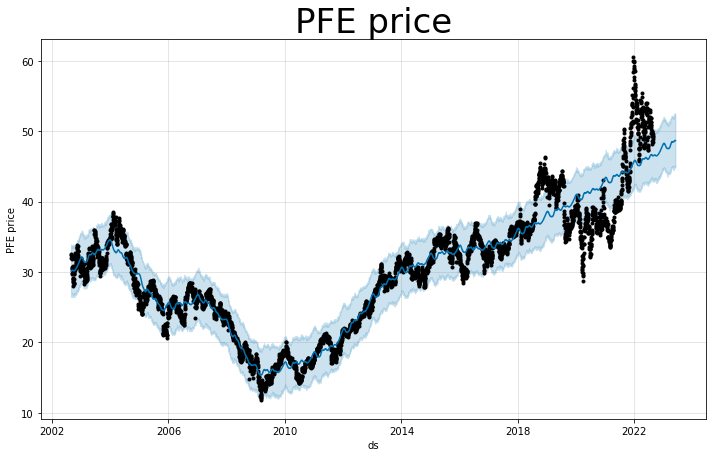

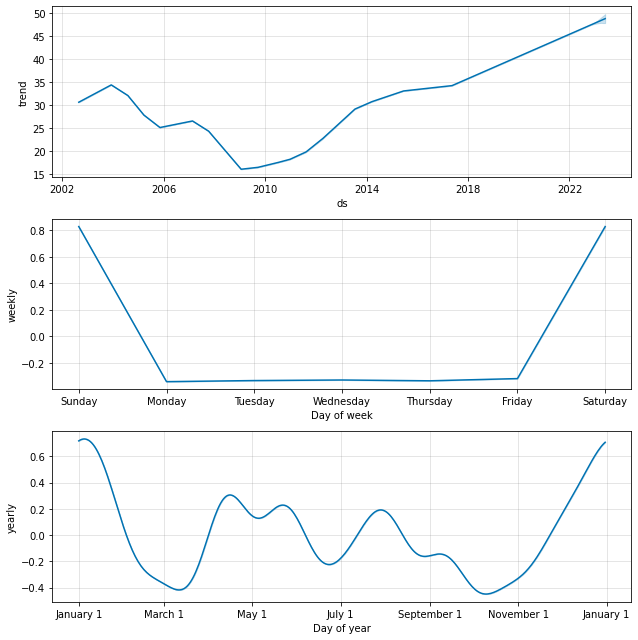

In [23]:
stock_list = ['MPC', #  Marathon Petroleum Corporation 
              'DVN', #  DEVON ENERGY
              'WMT', # WALMART
              'PFE' # PFITZER
             ]

forecast_all(stock_list, 40)

### Don't forget to give an upvote if you find this notebook helpful
## 
## END